### Census API: U.S. exports by partner


*Brian Dew, @bd_econ, January 2026*

The Census Bureau allows API access to data on international trade. This example retrieves the October 2025 US export values by partner. Documentation for the Census international trade API is [here](https://www.census.gov/data/developers/data-sets/international-trade.html). The list of variables is [here](https://api.census.gov/data/timeseries/intltrade/exports/hs/variables.html)

#### Requirements:

Python (3.7 used), requests, pandas.

Also requires API key, free from Census, which I've stored locally in a file called config.py.

In [1]:
# import packages
import requests
import pandas as pd
from config import census_key as key

#### API Parameters/ Settings

In [2]:
# time series API: https://api.census.gov/data/timeseries.html
base = 'https://api.census.gov/data/timeseries/'
flow = 'intltrade/exports/hs'
param = 'CTY_CODE,CTY_NAME,ALL_VAL_MO'

# date needs manual update from release schedule:
# https://www.census.gov/foreign-trade/reference/release_schedule.html
time = '2025-10' 

url = f'{base}{flow}?get={param}&key={key}&time={time}'

#### Request data from API

In [3]:
# send request to census api and read response as json data
r = requests.get(url).json()

# print first five observations
r[:5]

[['CTY_CODE', 'CTY_NAME', 'ALL_VAL_MO', 'time'],
 ['-', 'TOTAL FOR ALL COUNTRIES', '202782649764', '2025-10'],
 ['0003', 'EUROPEAN UNION', '36239295190', '2025-10'],
 ['0014', 'PACIFIC RIM COUNTRIES', '42385528130', '2025-10'],
 ['0017', 'CAFTA-DR', '4055153818', '2025-10']]

#### Clean the data

The result is a list of observations, where each observation includes a country code, a country name, the value of exports, and the time period. I'm interested only in countries (not regional groupings) and the export value, so I select those two pieces of each observation's data, if the data cover a country (country code between 1000 and 8000).

In [4]:
# keep country name (pos 1) and export value in billions
d = [[i[1], int(i[2]) / 1000000000] for i in r 
     if i[0].isdigit() 
     and int(i[0]) in range(1000, 8000)] # country codes

d[:5]

[['GREENLAND', 0.000352469],
 ['MEXICO', 29.575129143],
 ['CANADA', 29.20703605],
 ['ST PIERRE AND MIQUELON', 0.0],
 ['GUATEMALA', 0.853784274]]

In [5]:
data = (pd.Series(dict(d)).sort_values())

data.tail()

CHINA              8.950493
UNITED KINGDOM    11.699702
SWITZERLAND       12.682343
CANADA            29.207036
MEXICO            29.575129
dtype: float64

#### Plot the top 20 partners by export volume

I'm partial to very simple horizontal bar plots with no axis. Making these with matplotlib becomes intuitive after a bit of practice. Basically, I just add each element that I want to show: a title, country labels, blue bars in lengths according to the series values, series value labels, and a footer. 

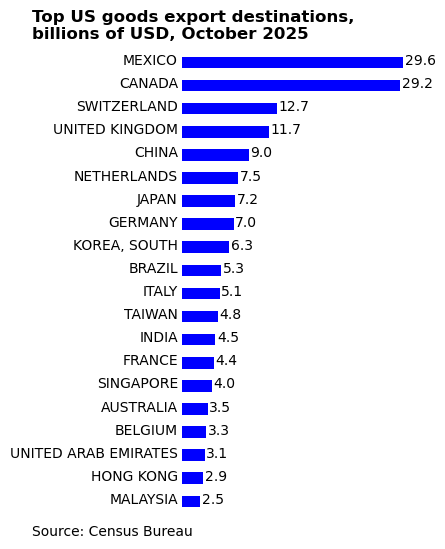

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot top 20 partners
s = data.tail(20)
s.plot(kind='barh', figsize=(3,6), color='blue')

# add value labels to ends of bars and country names to start of bars
for i, val in enumerate(s):
    plt.text(val+0.2, i-0.11, f'{val:.1f}')
    plt.text(-0.5, i-0.11, s.index[i], ha='right')
    
# add title and footer
plt.text(-20, 20, 'Top US goods export destinations,\nbillions of USD, October 2025', 
          fontsize=12, weight='bold')
plt.text(-20, -1.5, 'Source: Census Bureau')

plt.axis('off')
plt.show()

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import config

key = config.census_key

In [10]:
base = 'https://api.census.gov/data/timeseries/intltrade/exports/hs'
param = 'CTY_CODE,CTY_NAME,ALL_VAL_MO'
time = '2025-10'

url = f'{base}?get={param}&key={key}&time={time}'

In [11]:
r = requests.get(url)

if r.status_code == 200:
    data = r.json()
else:
    print(f'Error: {r.status_code}')

In [12]:
data[:3]

[['CTY_CODE', 'CTY_NAME', 'ALL_VAL_MO', 'time'],
 ['-', 'TOTAL FOR ALL COUNTRIES', '202782649764', '2025-10'],
 ['0003', 'EUROPEAN UNION', '36239295190', '2025-10']]

In [22]:
df = pd.DataFrame(data[1:], columns=data[0])

# Filter to individual countries only (exclude aggregates)
df = df.loc[df['CTY_CODE'].str.isdigit()]
df['CTY_CODE'] = df['CTY_CODE'].astype(int)
df = df[(df['CTY_CODE'] >= 1000) & (df['CTY_CODE'] < 8000)]

# Convert to billions
df['ALL_VAL_MO'] = df['ALL_VAL_MO'].astype(float) / 1e9

In [23]:
top20 = (df.sort_values('ALL_VAL_MO', ascending=True)
           .tail(20)
           .set_index('CTY_NAME')['ALL_VAL_MO'])

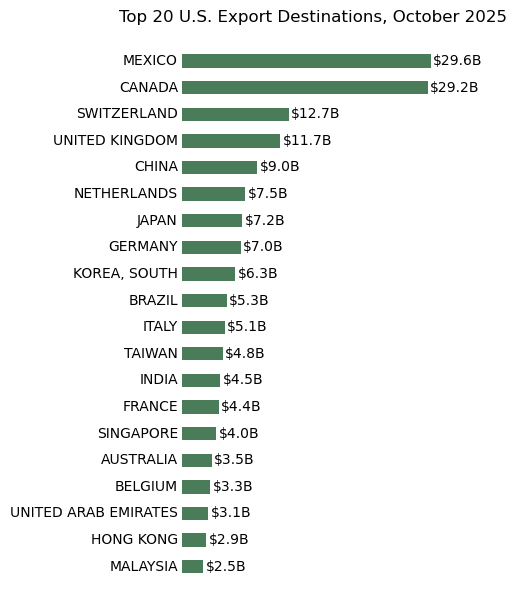

In [26]:
fig, ax = plt.subplots(figsize=(5, 6))
top20.plot(kind='barh', ax=ax, color='#4a7c59')
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')

# Add value labels
for i, (country, val) in enumerate(top20.items()):
    ax.text(-0.5, i, country, ha='right', va='center', fontsize=10)
    ax.text(val + 0.3, i, f'${val:.1f}B', ha='left', va='center', fontsize=10)

ax.set_title('Top 20 U.S. Export Destinations, October 2025\n', fontsize=12)
plt.tight_layout()
plt.show()